### Quality Assurance
This Jupyter Notebook includes all code snippets for processing individual datasets and generating various plots for quality assurance (QA). 

# Import Packages

In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy import stats

# Append Files

In [6]:
def append_files(path, file_pattern='*[mono|R]_features*', file_name='group_R_features.csv'):
    '''
    Append subject files (eye/behavior) and save as a group .csv file

    Parameters
    ----------
    path : string
        DESCRIPTION. The relative path to the data folder
    file_pattern : string, optional
        DESCRIPTION. The pattern for files being appended. 
        The default is '*[mono|R]_features*' for eye feature files.
    file_name : string, optional
        DESCRIPTION. the group file name to save
        The default is 'group_R_features.csv'.

    Returns
    -------
    df_group : dataframe
        DESCRIPTION. The group dataframe 

    '''
    # grab every sub folders under the input path
    sub_folders = [f.path for f in os.scandir(path) if f.is_dir()]
    # define group dataframe
    df_group = pd.DataFrame()
    
    # loop through every folder
    for folder_path in sub_folders:
        try: 
            # extract subject id
            subject_id = re.findall(r's[0-9]+', folder_path)[0]
            # extract tracking and behavior features
            file_path = glob(os.path.join(folder_path, file_pattern))
            # read in the subject csv
            df_ind = pd.read_csv(file_path[0])
            # add subject id columne
            df_ind['sub_id'] = subject_id
            # append to the group dataframe
            df_group = pd.concat([df_group, df_ind], ignore_index=True)
        except:
            continue
    
    # save and return the group dataframe
    df_group = df_group.loc[:, ~df_group.columns.str.match('Unnamed')]
    
    # calculate z-score of two correlation coefficient columns
    # zipf_duration_correlation and word_length_duration_correlation
    for col_name in ['zipf_fixdur_corr', 'word_length_fixdur_corr']:
        # get index
        index = df_group.columns.get_loc(col_name)
        # extract the column values
        col = df_group[col_name]
        # compute the z-score
        z_col = stats.zscore(col, nan_policy='omit')
        # insert into the dataframe
        df_group.insert(index, f'zscored_{col_name}', z_col)
    
    df_group.to_csv(f'{path}{file_name}')
    return df_group

# call function to append individual dataset
path = '../../../../Data/'

# Default
# df = append_files(path, file_pattern='*[mono|R]_features_default*', file_name='group_R_features_default.csv')

# Same-dur
# df = append_files(path, file_pattern='*[mono|R]_features_same-dur*', file_name='group_R_features_same-dur.csv')

# Slide Window (window duration 5 seconds)
# df = append_files(path, file_pattern='*[mono|R]_features_slide_wlen5*', file_name='group_R_features_slide_wlen5.csv')

# Slide Window (window duration 2 seconds)
df = append_files(path, file_pattern='*[mono|R]_features_slide_wlen2*', file_name='group_R_features_slide_wlen2.csv')

# Generate Label Files

In [31]:
# Load the first dataset and expand it
file_path1 = '../../../../Data/group_R_features_default.csv'
df1 = pd.read_csv(file_path1)

# Filter only MW-reported cases
df1 = df1[df1['is_MWreported']]
# Add a new column for self_report event time
df1['self_report'] = df1['page_end']
# Expand df1: Convert MW_start, MW_end, and self_report into separate rows
df1_expanded = df1.melt(
    id_vars=['sub_id', 'run', 'page', 'task_start', 'page_start', 'page_end'],
    value_vars=['MW_start', 'MW_end', 'self_report'],
    var_name='label',
    value_name='event_time'
)

# Rename labels for clarity
label_mapping = {'MW_start': 'MW_onset', 'MW_end': 'MW_offset', 'self_report': 'self_report'}
df1_expanded['label'] = df1_expanded['label'].map(label_mapping)


# Load the second dataset
file_path2 = '../../../../Data/group_R_features_slide_wlen2.csv'
df2 = pd.read_csv(file_path2)

# Filter df2 where label == 'control' and relative_time == 0
df2 = df2[(df2['relative_time'] == 0) & (df2['label'] == 'control')].copy()
# Compute event_time for control events
df2['event_time'] = (df2['win_start'] + df2['win_end']) / 2
# Keep only relevant columns
df2 = df2[['sub_id', 'run', 'page', 'task_start', 'page_start', 'page_end', 'event_time', 'label']]

# Merge the two datasets
df = pd.concat([df1_expanded, df2], ignore_index=True)
# Sort the dataset for logical ordering
df = df.sort_values(by=['sub_id', 'run', 'page']).reset_index(drop=True)
# Remove duplicate `self_report` entries per sub_id, run, and page
df = df.drop_duplicates()

### Compute Time Before & After Events ###
# Compute time_before_event (default: event_time - page_start)
df['time_before_event'] = df['event_time'] - df['page_start']
# Compute time_after_event (default: page_end - event_time)
df['time_after_event'] = df['page_end'] - df['event_time']

# Create lookup dictionaries for MW_onset and MW_offset event times
mw_onset_times = df[df['label'] == 'MW_onset'].set_index(['sub_id', 'run', 'page'])['event_time']
mw_offset_times = df[df['label'] == 'MW_offset'].set_index(['sub_id', 'run', 'page'])['event_time']

# Assign time_after_event for MW_onset based on MW_offset
df.loc[df['label'] == 'MW_onset', 'time_after_event'] = df[df['label'] == 'MW_onset'].apply(
    lambda row: mw_offset_times.get((row['sub_id'], row['run'], row['page']), np.nan) - row['event_time'],
    axis=1
)

# Assign time_before_event for MW_offset from MW_onset's time_after_event
mw_onset_time_after = df[df['label'] == 'MW_onset'].set_index(['sub_id', 'run', 'page'])['time_after_event']
df.loc[df['label'] == 'MW_offset', 'time_before_event'] = df[df['label'] == 'MW_offset'].apply(
    lambda row: mw_onset_time_after.get((row['sub_id'], row['run'], row['page']), np.nan),
    axis=1
)

# Assign time_before_event for self_report using MW_offset times
df.loc[df['label'] == 'self_report', 'time_before_event'] = df[df['label'] == 'self_report'].apply(
    lambda row: row['event_time'] - mw_offset_times.get((row['sub_id'], row['run'], row['page']), np.nan),
    axis=1
)

# Ensure final column order
df = df[['sub_id', 'run', 'page', 'task_start', 'page_start', 'page_end', 'event_time', 'time_before_event', 'time_after_event', 'label']]

# Reset index for clean output
df = df.reset_index(drop=True)

# Save to CSV file
output_path = '../../../../Data/group_event_label.csv'
df.to_csv(output_path)


# Load Dataset

In [7]:
# Default
#file_path = '../../../../Data/group_R_features_default.csv'

# Same-dur
#file_path = '../../../../Data/group_R_features_same-dur.csv'

# Slide Window (window duration 5 seconds)
#file_path = '../../../../Data/group_R_features_slide_wlen5.csv'

# Slide Window (window duration 2 seconds)
file_path = '../../../../Data/group_R_features_slide_wlen2.csv'

df = pd.read_csv(file_path)

# Line Plot for different eye-features

C:\Users\11376\AppData\Local\Temp\ipykernel_2564\815775044.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 3))


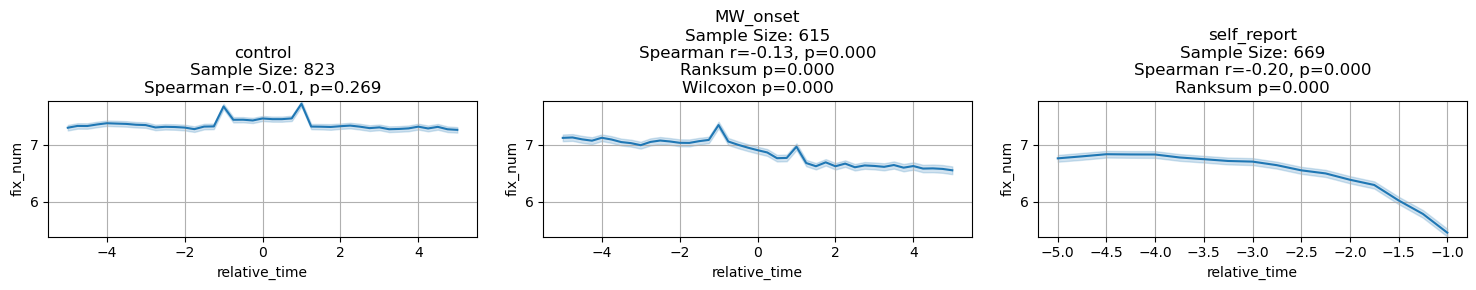

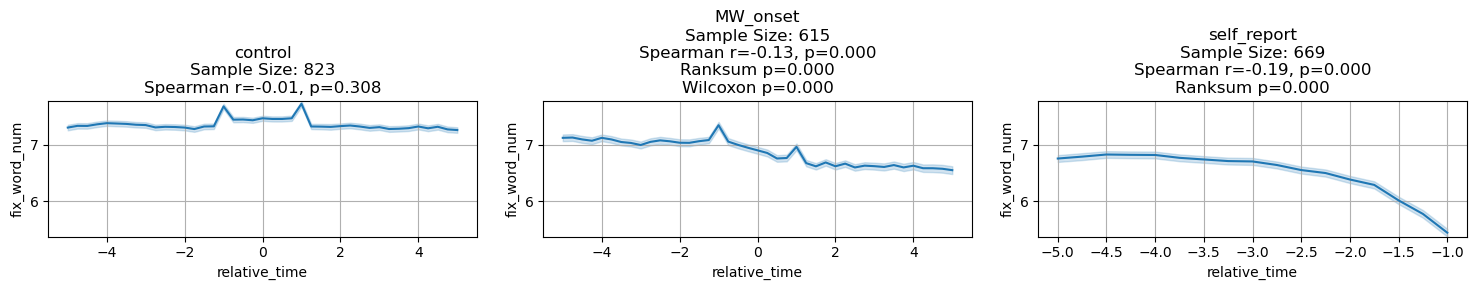

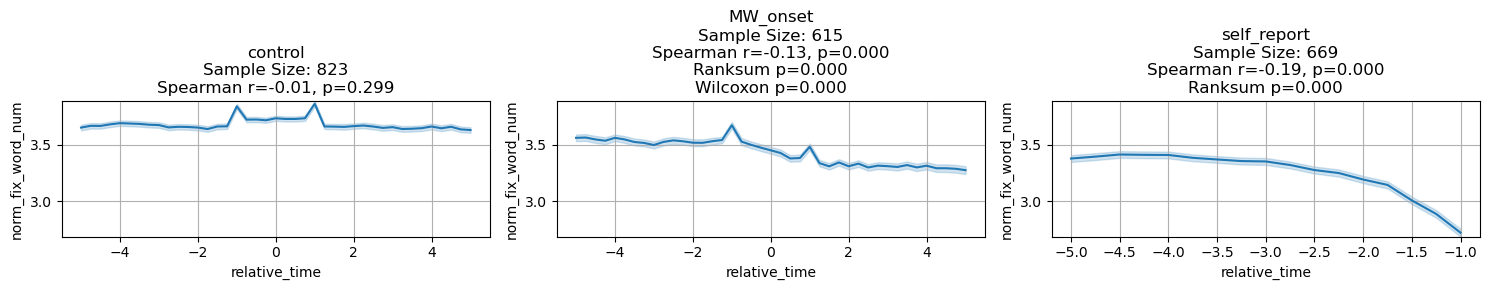

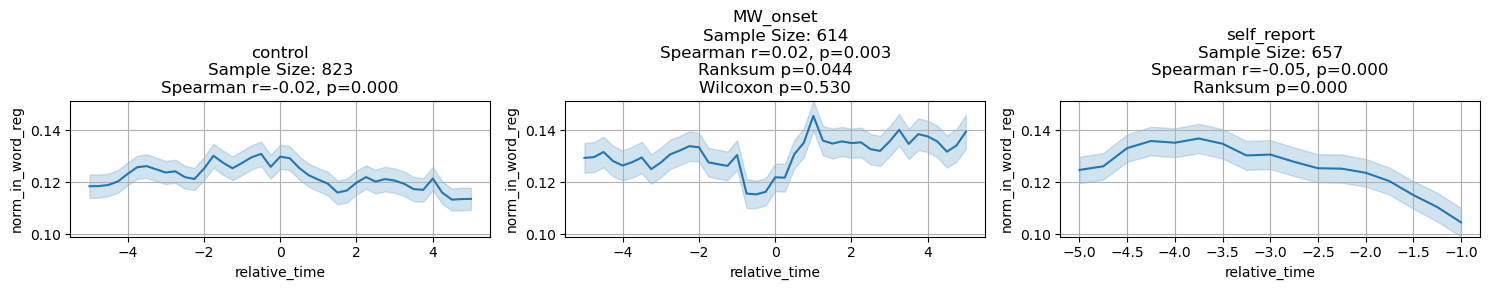

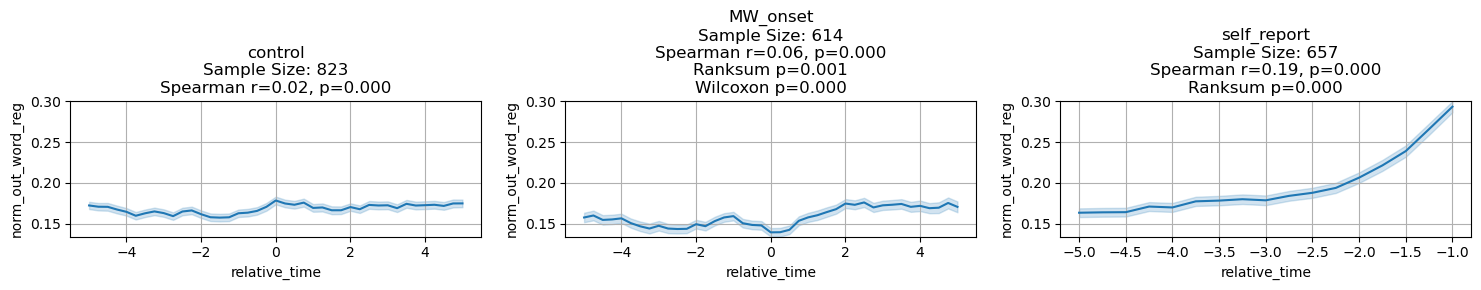

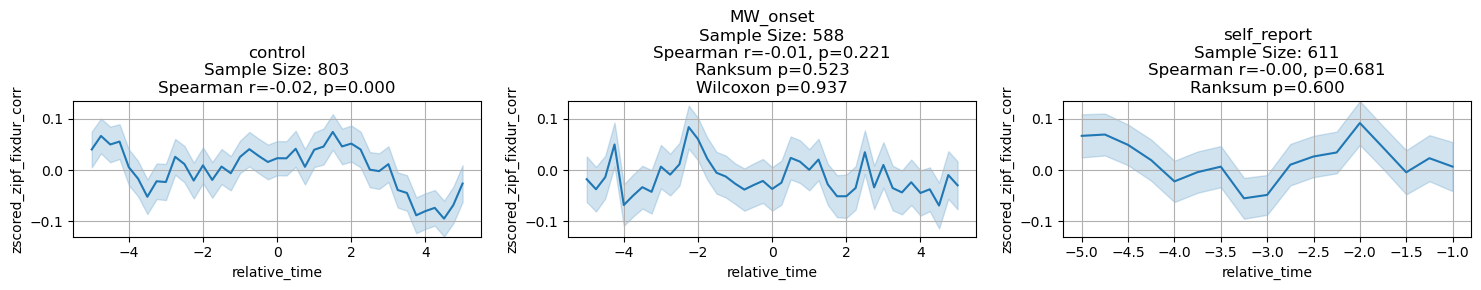

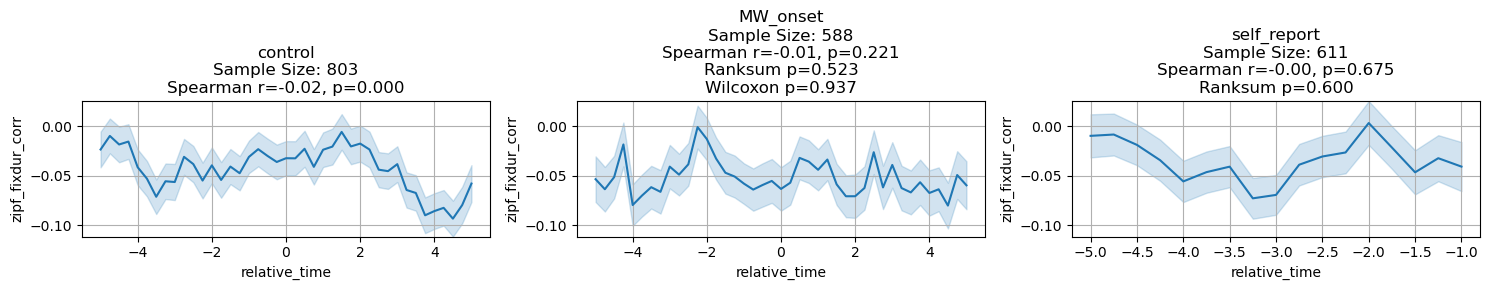

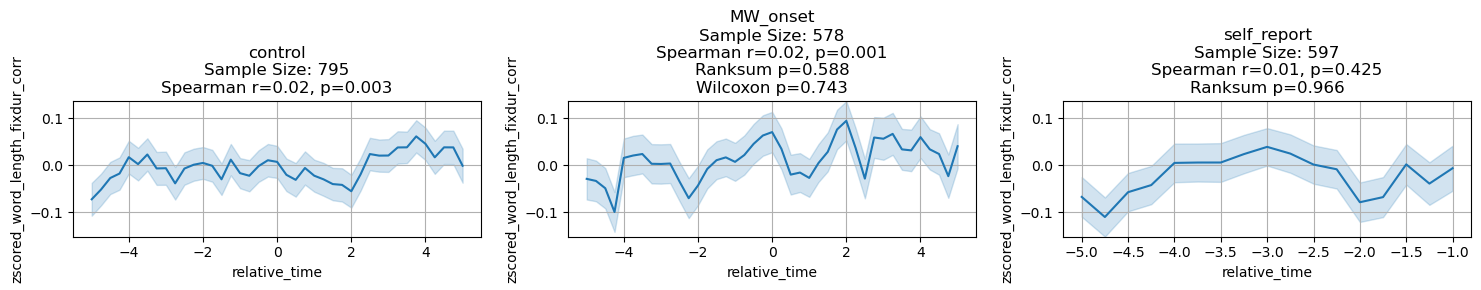

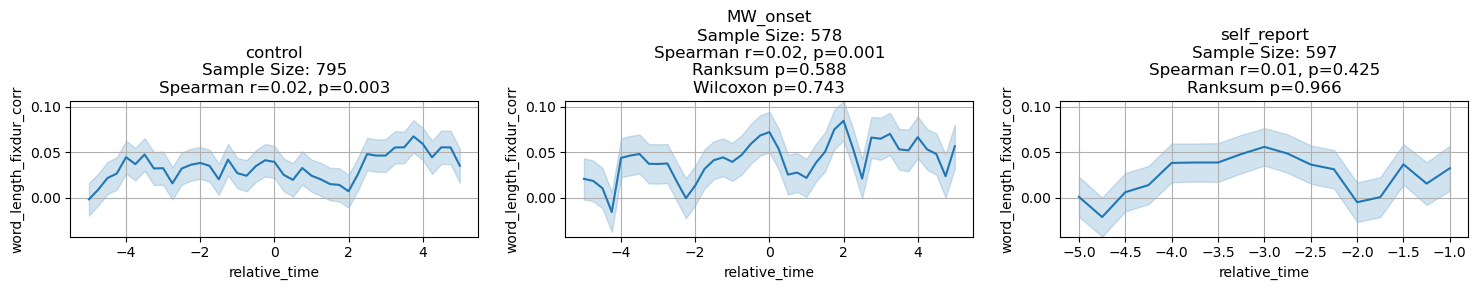

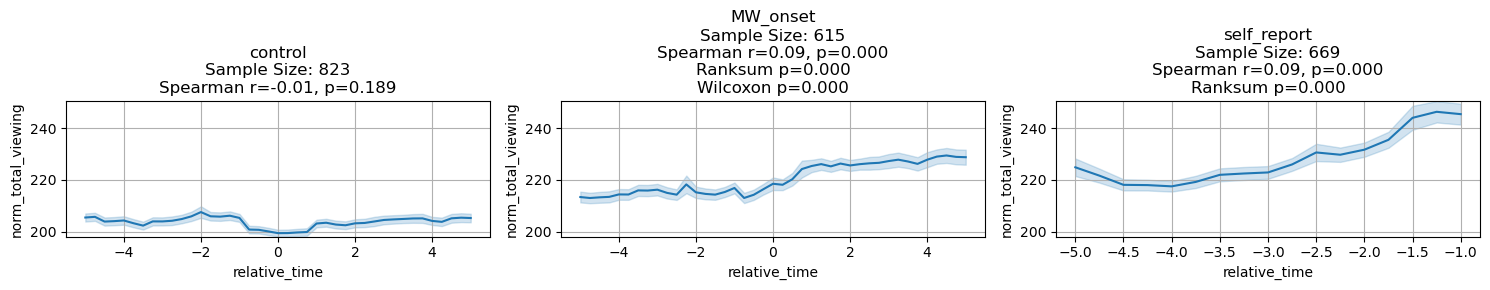

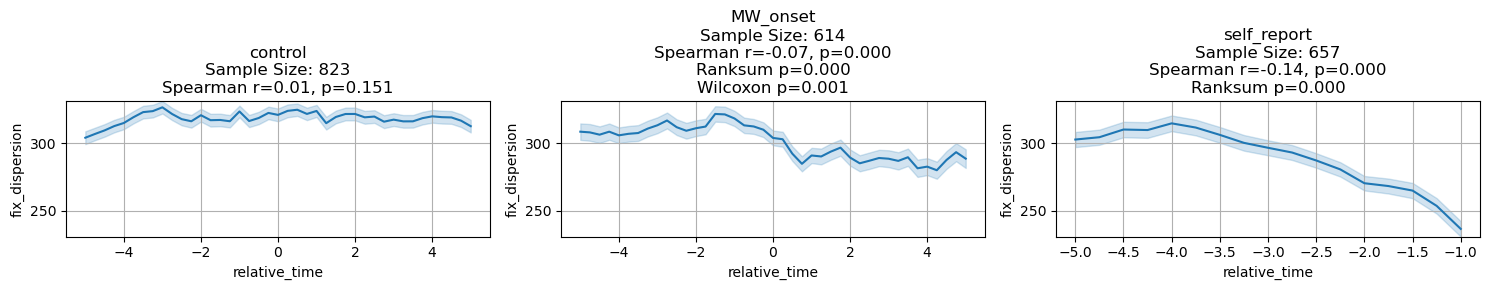

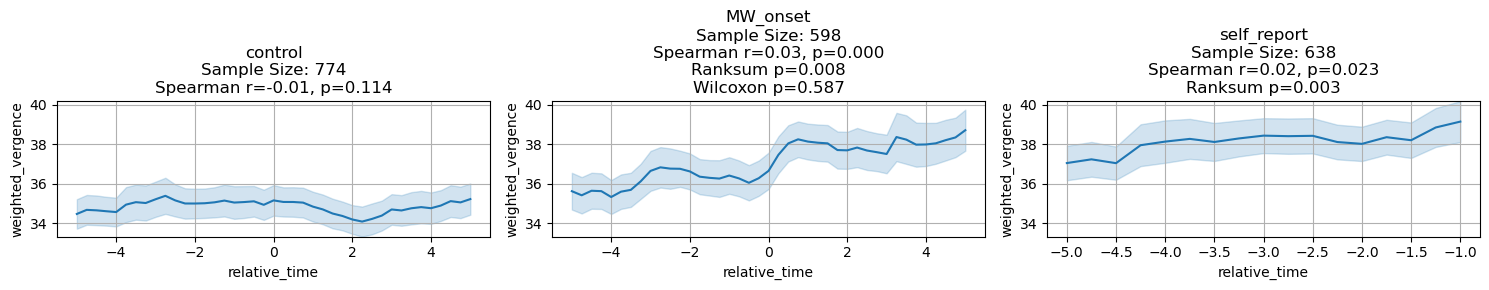

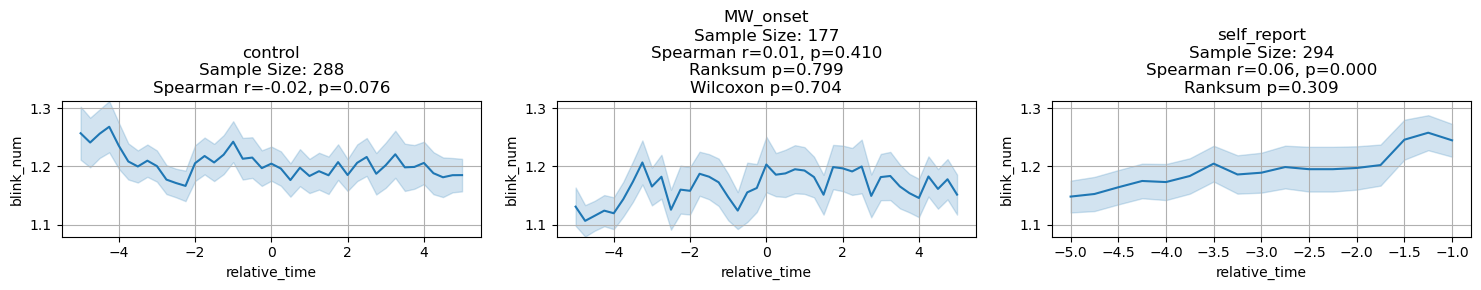

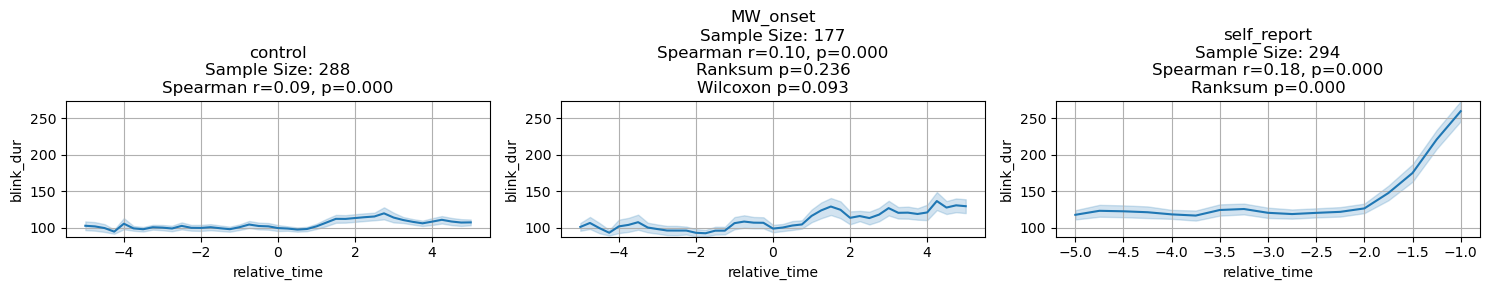

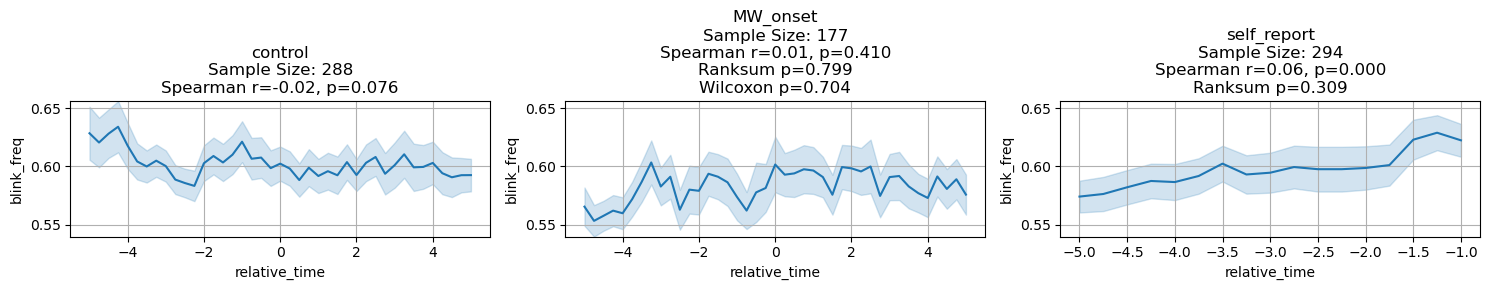

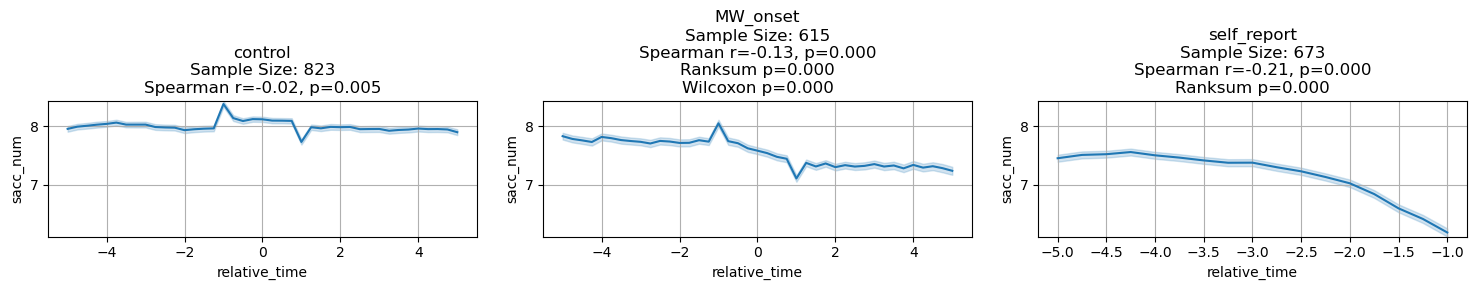

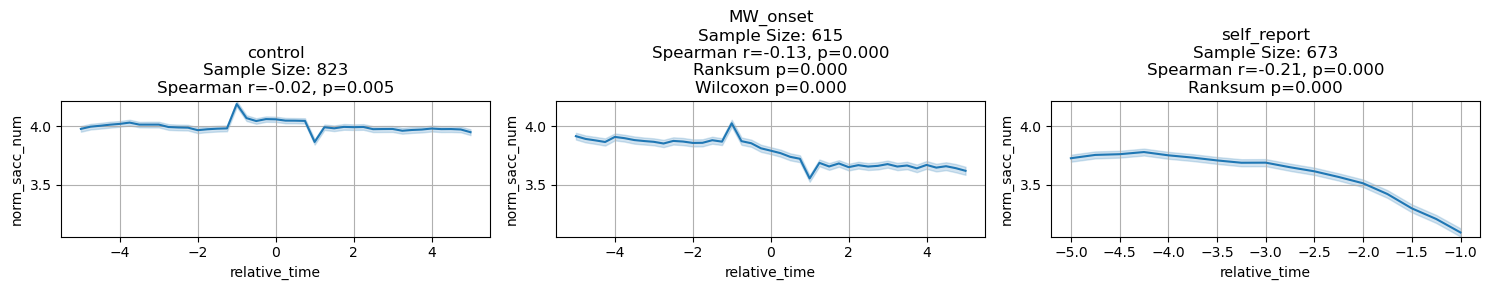

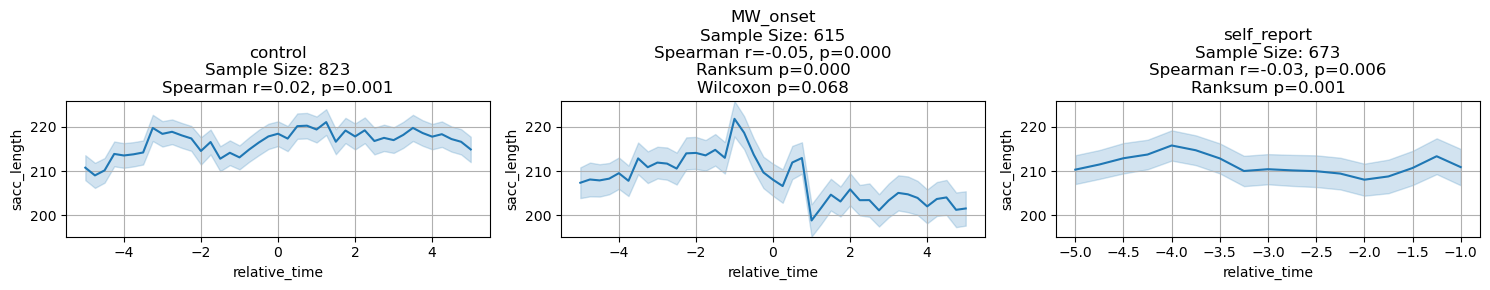

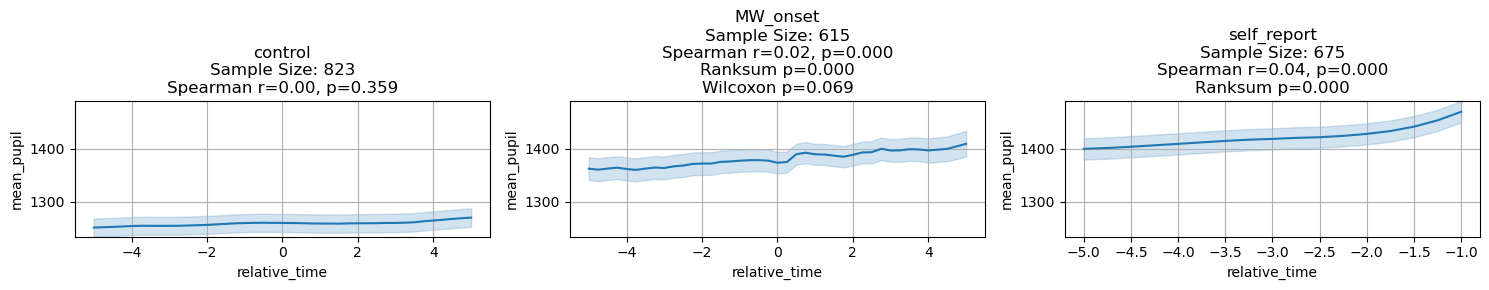

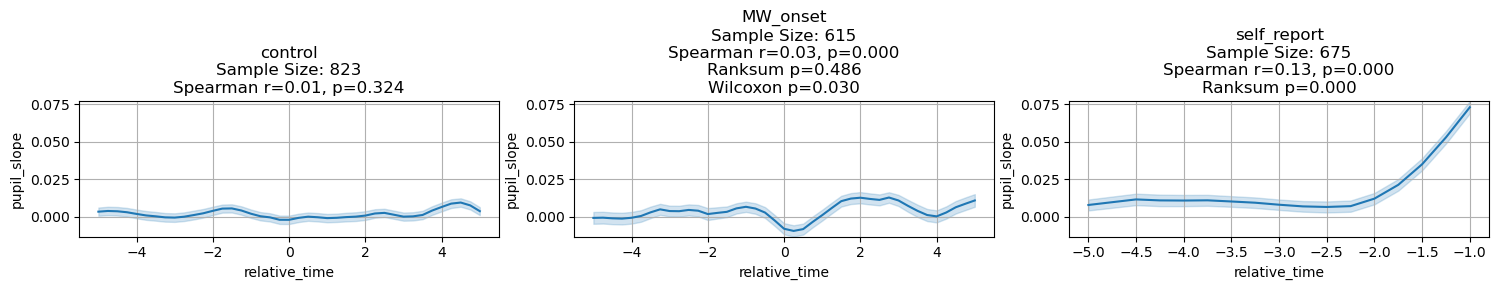

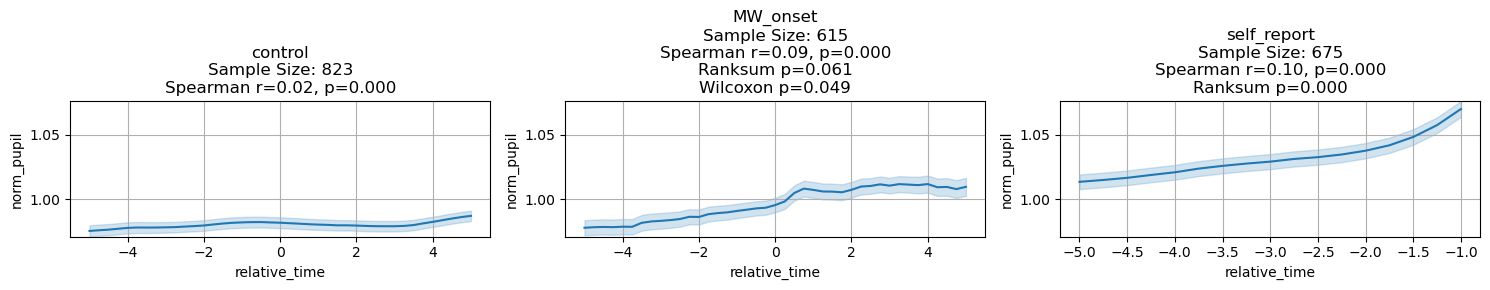

In [8]:
# Define full range of relative_time values (-5 to 5 with step 0.25)
time_range = np.arange(-5, 5.25, 0.25)  # Ensures 5 is included
win_len = 2

# List of features to analyze
features = [
    'fix_num', 'fix_word_num', 'norm_fix_word_num', 'norm_in_word_reg', 
    'norm_out_word_reg', 'zscored_zipf_fixdur_corr', 'zipf_fixdur_corr', 
    'zscored_word_length_fixdur_corr', 'word_length_fixdur_corr', 'norm_total_viewing', 
    'fix_dispersion', 'weighted_vergence', 'blink_num', 'blink_dur', 'blink_freq', 
    'sacc_num', 'norm_sacc_num', 'sacc_length', 'mean_pupil', 'pupil_slope', 'norm_pupil'
]

for feature in features:
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    # Store y-axis limits based on standard error
    y_min, y_max = np.inf, -np.inf  

    # Ranksum Test: Compare Control (t=0) vs MW_onset (t=1) / Self-report (t=-1)
    control_data = df[(df['label'] == 'control') & (df['relative_time'] == 0)][feature].dropna()
    mw_onset_data = df[(df['label'] == 'MW_onset') & (df['relative_time'] == 1)][feature].dropna()
    self_report_data = df[(df['label'] == 'self_report') & (df['relative_time'] == -(win_len/2))][feature].dropna()

    _, ranksum_p_mw = stats.ranksums(control_data, mw_onset_data, nan_policy='omit') if len(control_data) > 1 and len(mw_onset_data) > 1 else (np.nan, np.nan)
    _, ranksum_p_sr = stats.ranksums(control_data, self_report_data, nan_policy='omit') if len(control_data) > 1 and len(self_report_data) > 1 else (np.nan, np.nan)

    for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
        # Filter dataset for the current condition
        df_condition = df[df['label'] == condition]

        # Pivot: Convert 'relative_time' to columns while keeping ('sub_id', 'run', 'page') as index
        df_wide = df_condition.pivot_table(index=['sub_id', 'run', 'page'], columns='relative_time', values=feature)

        # Reindex to ensure all relative_time columns exist
        df_wide = df_wide.reindex(columns=time_range)

        # Convert back to long format
        df_long = df_wide.reset_index().melt(id_vars=['sub_id', 'run', 'page'], var_name='relative_time', value_name=feature)
        df_long['relative_time'] = df_long['relative_time'].astype(float)  # Ensure numeric ordering

        # Compute average across `run` and `page`
        df_avg = df_long.groupby(['relative_time'])[feature].mean().reset_index()
        df_se = df_long.groupby(['relative_time'])[feature].sem().reset_index()  # Compute standard error

        # Determine min/max y-values based on SE bands
        y_min = min(y_min, (df_avg[feature] - df_se[feature]).min())
        y_max = max(y_max, (df_avg[feature] + df_se[feature]).max())

        # Compute Non-NaN sample size at reference time
        reference_time = -(win_len/2) if condition == 'self_report' else 0
        sample_data = df_long[df_long['relative_time'] == reference_time][feature].dropna()
        sample_size = len(sample_data)

        # Compute Spearman's correlation
        spearman_r, spearman_p = stats.spearmanr(df_long["relative_time"], df_long[feature], nan_policy="omit")

        # Plot lineplot with error bars (mean ± standard error)
        sns.lineplot(
            data=df_long, 
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            ax=ax
        )

        # Initialize title text
        title_text = f"{condition}\nSample Size: {sample_size}\nSpearman r={spearman_r:.2f}, p={spearman_p:.3f}"

        # Wilcoxon Test for MW_onset (-2.5 vs 2.5)
        if condition == 'MW_onset':
            pre_onset = df_wide[-2.5]
            post_onset = df_wide[2.5]
            title_text += f"\nRanksum p={ranksum_p_mw:.3f}"
            if len(pre_onset) > 1 and len(post_onset) > 1:
                _, wilcoxon_p = stats.wilcoxon(pre_onset, post_onset, nan_policy='omit')
                title_text += f"\nWilcoxon p={wilcoxon_p:.3f}"

        # Add Ranksum p-values
        if condition == 'self_report':
            title_text += f"\nRanksum p={ranksum_p_sr:.3f}"

        # Update plot title
        ax.set_title(title_text)
        ax.grid()

    # Set y-limits based on computed SE range
    for ax in axes:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig(f'../../../../Results/LinePlot/{feature}_win{win_len}.png')